## Bibliotecas

In [24]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.spatial import distance_matrix
from adjustText import adjust_text
from matplotlib.patches import Polygon

## Datos

In [25]:
# Ruta al archivo
file_path = "../data/Towns_HB_2024-08-14.xlsx"

# Leer todas las hojas como un diccionario {nombre_hoja: DataFrame}
all_sheets = pd.read_excel(file_path, sheet_name=None)

# Filtrar solo las hojas que tienen datos (al menos una fila no vacía)
non_empty_sheets = {name: df for name, df in all_sheets.items() if not df.dropna(how='all').empty}

# Mostrar nombres de hojas con datos
print(f"Hojas con datos: {list(non_empty_sheets.keys())}")

Hojas con datos: ['Towns', 'Triple Alliance towns', 'Tenochtitlan', 'Zempoala', '79 Destinations', 'Tecpilpan']


In [26]:
df_towns = non_empty_sheets["Towns"]
df_triple_alliance = non_empty_sheets["Triple Alliance towns"]
df_tenochtitlan = non_empty_sheets["Tenochtitlan"]
df_zempoala = non_empty_sheets["Zempoala"]
df_79 = non_empty_sheets["79 Destinations"]
df_tecpilpan = non_empty_sheets["Tecpilpan"]

### Definir coordenadas y pueblos

In [27]:
coords = df_towns[["Longitude", "Latitude"]].values
names = df_towns["Toponym"].values

### Muestra de cinco datos

In [28]:
# Indices you want (zero-based)
indices = [67, 68, 70, 71]

# Get names by index
selected_names = names[indices]
selected_coords = coords[indices]
print(selected_names)

['Tezontepec 2 (de Aldama); Teçuntepeque' 'Mizquiyahualan' 'Tezcatepec'
 'Chilcuauhtlan']


In [29]:
# Extract longitude and latitude
longitudes = selected_coords[:, 0]
latitudes = selected_coords[:, 1]

# Identify points
chalco_idx = np.where(selected_names == 'Mizquiyahualan')[0][0]
tlalmanalco_idx = np.where(selected_names == 'Chilcuauhtlan')[0][0]

chalco = selected_coords[chalco_idx]
tlalmanalco = selected_coords[tlalmanalco_idx]

# Compute Euclidean distance (in degrees)
radius = np.linalg.norm(chalco - tlalmanalco)

In [30]:
# === Define triangle points ===

# Get index of each point in selected_names
idx_mizqui = np.where(selected_names == 'Mizquiyahualan')[0][0]
idx_tezca = np.where(selected_names == 'Tezcatepec')[0][0]
idx_tezonte = np.where(selected_names == 'Tezontepec 2 (de Aldama); Teçuntepeque')[0][0]
idx_chilcua = np.where(selected_names == 'Chilcuauhtlan')[0][0]

# Triangle 1 coordinates
triangle1_coords = np.array([
    selected_coords[idx_mizqui],
    selected_coords[idx_tezca],
    selected_coords[idx_chilcua]
])

# Triangle 2 coordinates
triangle2_coords = np.array([
    selected_coords[idx_mizqui],
    selected_coords[idx_tezonte],
    selected_coords[idx_chilcua]
])


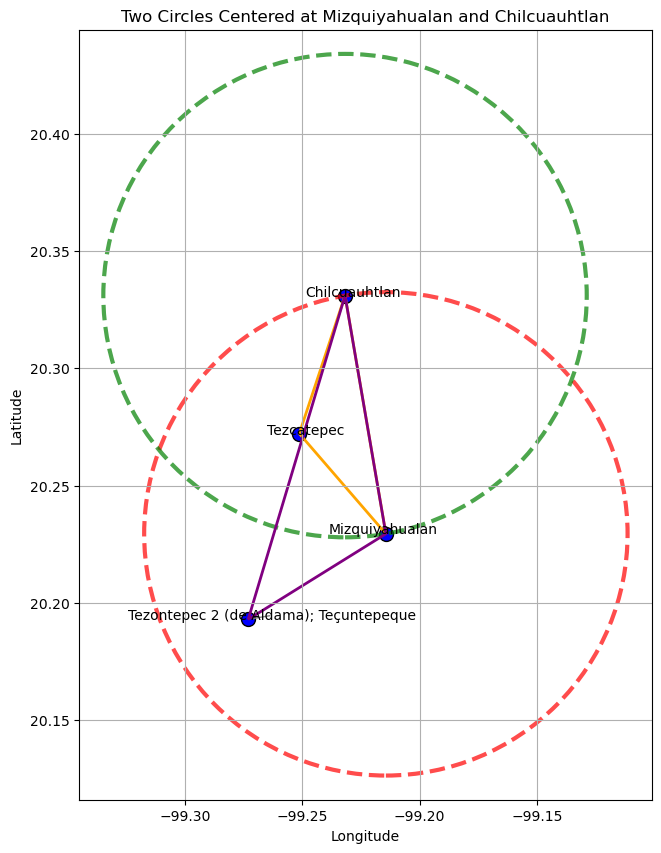

In [32]:
# Update the figure size and padding
fig, ax = plt.subplots(figsize=(12, 10))  # Bigger figure

# Scatter points
ax.scatter(longitudes, latitudes, c='blue', s=100, edgecolors='black')

# Labels
texts = [ax.text(x, y, name, fontsize=10) for x, y, name in zip(longitudes, latitudes, selected_names)]
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

# Circles with better visibility
circle_chalco = Circle(chalco, radius=radius, edgecolor='red', facecolor='none',
                       linestyle='--', linewidth=3, alpha=0.7)
circle_tlalma = Circle(tlalmanalco, radius=radius, edgecolor='green', facecolor='none',
                       linestyle='--', linewidth=3, alpha=0.7)
ax.add_patch(circle_chalco)
ax.add_patch(circle_tlalma)

# === Add triangles to the plot ===

# Add triangle 1 (e.g., orange outline only)
triangle1 = Polygon(triangle1_coords, closed=True, edgecolor='orange', facecolor='none', alpha=1.0, linewidth=2)
ax.add_patch(triangle1)

# Add triangle 2 (e.g., purple outline only)
triangle2 = Polygon(triangle2_coords, closed=True, edgecolor='purple', facecolor='none', alpha=1.0, linewidth=2)
ax.add_patch(triangle2)

# Axis config
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Two Circles Centered at Mizquiyahualan and Chilcuauhtlan")
ax.grid(True)
ax.set_aspect('equal')

# Adjust limits for padding around the circles
buffer = radius * 1.1
min_x = min(chalco[0], tlalmanalco[0]) - buffer
max_x = max(chalco[0], tlalmanalco[0]) + buffer
min_y = min(chalco[1], tlalmanalco[1]) - buffer
max_y = max(chalco[1], tlalmanalco[1]) + buffer
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)

plt.show()


## Algoritmo

### Calculo de la matriz de distancias

(i)    Calcular la distancia entre todos los pares de puntos $d(p_i,P_j)$, con $i, j = 1, 2, ..., n$; y $i>j$

In [37]:
def euclidean_distance_matrix_symmetric(coords):
    """
    Computes a symmetric Euclidean distance matrix (in degrees),
    only calculating the upper triangle to save computation.

    Parameters:
        coords (np.ndarray): Array of shape (n, 2), where each row is [lon, lat].

    Returns:
        np.ndarray: A (n x n) symmetric matrix of distances.
    """
    n = coords.shape[0]
    dist_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):  # Only compute upper triangle
            dist = np.linalg.norm(coords[i] - coords[j])
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist  # Symmetric

    return dist_matrix


In [38]:
dist_matrix = euclidean_distance_matrix(coords)

### Calcular dmax

In [39]:
import numpy as np

def compute_dmax_for_all_pairs(D):
    """
    For each pair (i, j), compute:
    dmax_ij = min_k max(D[i, k], D[j, k]) over all k ≠ i, k ≠ j.

    Parameters:
        D (np.ndarray): Symmetric distance matrix of shape (n, n)

    Returns:
        dmax_matrix (np.ndarray): Matrix of shape (n, n), where [i, j] contains dmax_ij
    """
    n = D.shape[0]
    dmax_matrix = np.full((n, n), np.inf)

    for i in range(n):
        for j in range(i + 1, n):
            dmax_k = [
                max(D[i, k], D[j, k])
                for k in range(n)
                if k != i and k != j
            ]
            dmax_ij = min(dmax_k)
            dmax_matrix[i, j] = dmax_ij
            dmax_matrix[j, i] = dmax_ij  # symmetry

    return dmax_matrix


In [40]:
import numpy as np

def compute_rng_adjacency_matrix(D):
    """
    Compute the adjacency matrix of the Relative Neighborhood Graph (RNG),
    based on the distance matrix D.

    Parameters:
        D (np.ndarray): Symmetric (n x n) distance matrix.

    Returns:
        adj (np.ndarray): Symmetric (n x n) RNG adjacency matrix (0 or 1).
    """
    n = D.shape[0]
    adj = np.zeros((n, n), dtype=int)

    for i in range(n):
        for j in range(i + 1, n):
            d_ij = D[i, j]
            keep_edge = True

            for k in range(n):
                if k != i and k != j:
                    d_max_k = max(D[i, k], D[j, k])
                    if d_ij > d_max_k:
                        keep_edge = False
                        break

            if keep_edge:
                adj[i, j] = 1
                adj[j, i] = 1  # symmetry

    return adj


In [41]:
coords = df_towns[["Longitude", "Latitude"]].values
D = euclidean_distance_matrix_symmetric(coords)
adj_rng = compute_rng_adjacency_matrix(D)


In [42]:
adj_rng

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [49]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from adjustText import adjust_text

def plot_rng_network(adj_matrix, coords, labels=None, node_size=100, figsize=(15, 15)):
    """
    Plots the Relative Neighborhood Graph (RNG) with non-overlapping labels.

    Parameters:
        adj_matrix (np.ndarray): Binary (n x n) adjacency matrix.
        coords (np.ndarray): Coordinates of nodes as (n x 2) array: [[lon, lat], ...]
        labels (list or array, optional): Node labels. If None, uses indices.
        node_size (int): Size of nodes in the plot.
        figsize (tuple): Size of the matplotlib figure.
    """
    G = nx.Graph()
    n = adj_matrix.shape[0]

    # Add nodes with positions
    for i in range(n):
        G.add_node(i, pos=(coords[i, 0], coords[i, 1]))

    # Add edges
    for i in range(n):
        for j in range(i + 1, n):
            if adj_matrix[i, j] == 1:
                G.add_edge(i, j)

    pos = nx.get_node_attributes(G, 'pos')

    # Start plot
    fig, ax = plt.subplots(figsize=figsize)

    nx.draw_networkx_edges(G, pos, ax=ax, edge_color='gray')
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_size, node_color='skyblue', edgecolors='black')

    if labels is not None:
        texts = []
        for i in range(n):
            x, y = coords[i]
            texts.append(ax.text(x, y, str(labels[i]), fontsize=8))
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5), ax=ax)

    ax.set_title("Relative Neighborhood Graph (RNG)")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_aspect('equal')
    ax.grid(True)
    plt.show()


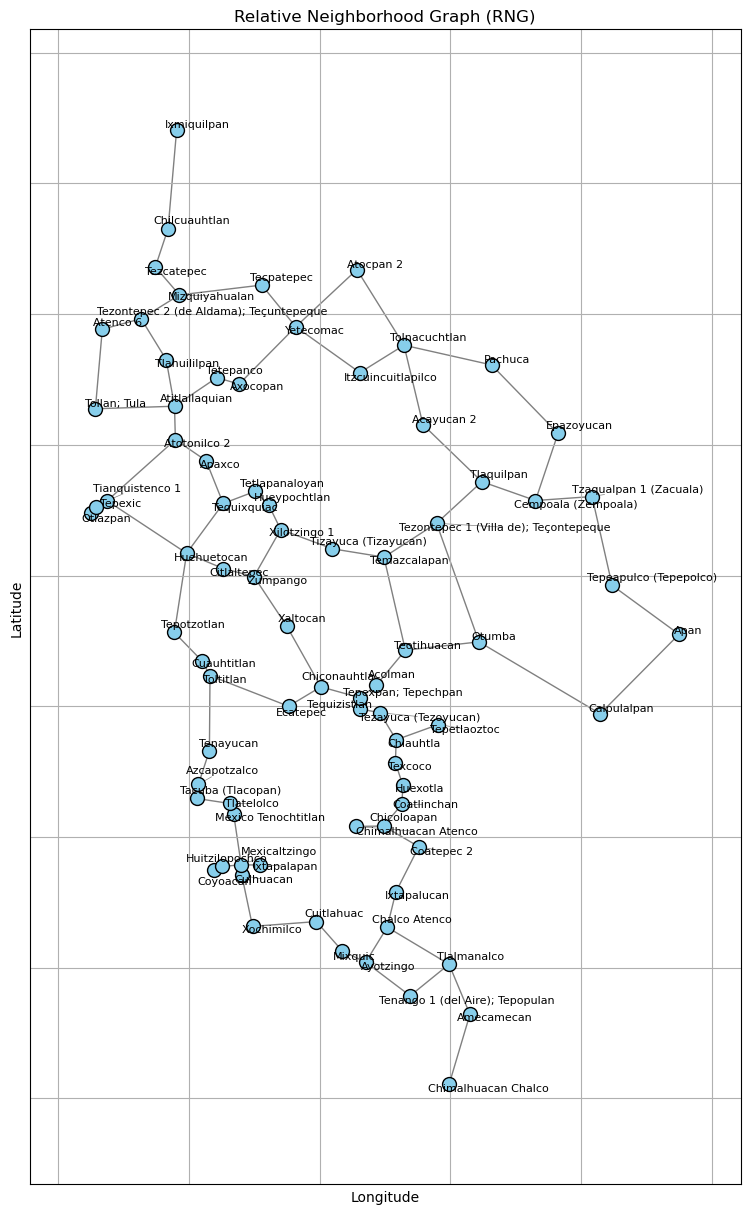

In [50]:
coords = df_towns[["Longitude", "Latitude"]].values
names = df_towns["Toponym"].values

D = euclidean_distance_matrix_symmetric(coords)
adj_rng = compute_rng_adjacency_matrix(D)

plot_rng_network(adj_rng, coords, labels=names)
